In [6]:
import os, glob, shutil
import netCDF4, tiledb, tiledb.cf
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

cfg = tiledb.Ctx().config()
cfg.update(
    {
        'py.init_buffer_bytes': 1024**2 * 50
    }
)
#tiledb.default_ctx(cfg)

# For plotting
marker='o'
linestyle=''
markersize=1

## Data Directory
# ceil_dir = "./data/sgpceilC1.b1"
ceil_dir = os.path.join(os.getcwd(), "data", "sgpceilC1.b1")

# sonde_dir = "./data/sgpsondewnpnC1.b1"
sonde_dir = os.path.join(os.getcwd(), "data", "sgpsondewnpnC1.b1")

## ---> COMMENT THIS OUT ONCE TESTING IS DONE
#
## NOTE: the following section reset the data directory.
#
# backup seed files
# backup_seed_ceil = "./sgpceilC1.b1/20200801.000015.nc"
backup_seed_ceil = os.path.join(os.getcwd(), "sgpceilC1.b1", "20200801.000015.nc")
# backup_seed_sonde = "./sgpsondewnpnC1.b1/20201101.232500.cdf"
backup_seed_sonde = os.path.join(os.getcwd(), "sgpsondewnpnC1.b1", "20201101.232500.cdf")
shutil.rmtree(ceil_dir, ignore_errors=True)
shutil.rmtree(sonde_dir, ignore_errors=True)
os.makedirs(ceil_dir, exist_ok=True)
os.makedirs(sonde_dir, exist_ok=True)
# copy the seed datafiles to the data directory
shutil.copy2(backup_seed_ceil, f"{ceil_dir}")
shutil.copy2(backup_seed_sonde, f"{sonde_dir}")
#
## <--- COMMENT THIS OUT ONCE TESTING IS DONE

ceil_files = glob.glob(f"{ceil_dir}/*")
ceil_files.sort()
ceil_file = ceil_files[0]
# print(f"ceil file path : {ceil_file}")

sonde_files = glob.glob(f"{sonde_dir}/*")
sonde_files.sort()
sonde_file = sonde_files[0]
# print(f"sonde file path: {sonde_file}")

ceil_group_uri = f"{ceil_file}.tdb"
# print(f"ceil group uri : {ceil_group_uri}")
sonde_group_uri = f"{sonde_file}.tdb"
# print(f"sonde group uri: {sonde_group_uri}")

import cProfile
cpf = cProfile.Profile()

In [7]:
# profiles the conversion process for nc
cpf.enable()
ceil_converter = tiledb.cf.NetCDF4ConverterEngine(ceil_file)
ceil_converter = tiledb.cf.NetCDF4ConverterEngine.from_file(
    ceil_file,
    dim_dtype=np.uint32,
    attrs_filters=[tiledb.ZstdFilter(level=7)],
)
# # ceil_converter
ceil_converter.convert_to_group(ceil_group_uri)

# # ceil_group_schema = tiledb.cf.GroupSchema.load(ceil_group_uri)
# # ceil_group_schema

cpf.disable()
cpf.print_stats('cumtime')


         9729 function calls (9715 primitive calls) in 1.310 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.000    0.000    1.309    0.327 interactiveshell.py:3215(run_code)
        4    0.000    0.000    1.309    0.327 {built-in method builtins.exec}
        1    0.000    0.000    1.291    1.291 converter.py:713(convert_to_group)
        1    0.000    0.000    1.117    1.117 converter.py:877(copy_to_group)
        1    0.000    0.000    1.117    1.117 converter.py:428(_copy_data)
        7    0.001    0.000    1.099    0.157 _array_converters.py:153(copy)
        7    0.791    0.113    0.963    0.138 _array_converters.py:43(_copy_to_array)
        1    0.000    0.000    0.174    0.174 creator.py:230(create_group)
        1    0.000    0.000    0.171    0.171 core.py:290(create)
        8    0.169    0.021    0.169    0.021 {built-in method create}
       36    0.000    0.000    0.169    0.005 _attr_conver

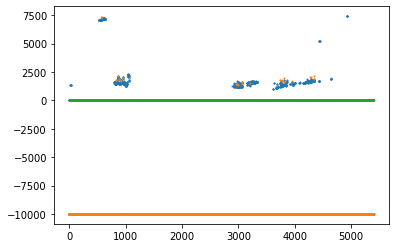

         156307 function calls (153165 primitive calls) in 1.578 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10    0.000    0.000    1.652    0.165 interactiveshell.py:3215(run_code)
       10    0.000    0.000    1.652    0.165 {built-in method builtins.exec}
        1    0.000    0.000    1.291    1.291 converter.py:713(convert_to_group)
        1    0.000    0.000    1.117    1.117 converter.py:877(copy_to_group)
        1    0.000    0.000    1.117    1.117 converter.py:428(_copy_data)
        7    0.001    0.000    1.099    0.157 _array_converters.py:153(copy)
        7    0.791    0.113    0.963    0.138 _array_converters.py:43(_copy_to_array)
        1    0.000    0.000    0.181    0.181 pyplot.py:323(show)
        1    0.000    0.000    0.181    0.181 backend_inline.py:23(show)
        1    0.000    0.000    0.174    0.174 creator.py:230(create_group)
        1    0.000    0.000    0.171    0.171 core.p

       40    0.001    0.000    0.002    0.000 ticker.py:753(_set_order_of_magnitude)
      131    0.000    0.000    0.002    0.000 <__array_function__ internals>:177(reshape)
      988    0.001    0.000    0.002    0.000 transforms.py:1783(__init__)
       36    0.000    0.000    0.002    0.000 transforms.py:670(<listcomp>)
  319/318    0.000    0.000    0.002    0.000 transforms.py:1796(transform)
       36    0.000    0.000    0.002    0.000 transforms.py:668(<listcomp>)
       42    0.000    0.000    0.002    0.000 <__array_function__ internals>:177(clip)
      340    0.000    0.000    0.002    0.000 <__array_function__ internals>:177(dot)
       10    0.000    0.000    0.002    0.000 <frozen importlib._bootstrap_external>:1527(find_spec)
      432    0.001    0.000    0.002    0.000 __init__.py:872(get_siblings)
       89    0.000    0.000    0.002    0.000 path.py:99(__init__)
  344/343    0.001    0.000    0.002    0.000 transforms.py:1862(transform_affine)
      168    0.000    

        6    0.000    0.000    0.001    0.000 _base.py:1055(_set_position)
     1428    0.001    0.000    0.001    0.000 transforms.py:1052(get_points)
       24    0.000    0.000    0.001    0.000 ntpath.py:77(join)
      180    0.000    0.000    0.001    0.000 font_manager.py:844(set_stretch)
        2    0.000    0.000    0.001    0.000 threading.py:582(wait)
      649    0.001    0.000    0.001    0.000 {built-in method numpy.asanyarray}
       11    0.000    0.000    0.001    0.000 _base.py:939(get_yaxis_text1_transform)
        1    0.000    0.000    0.001    0.001 <__array_function__ internals>:177(inv)
       42    0.000    0.000    0.001    0.000 ticker.py:1879(scale_range)
       16    0.000    0.000    0.001    0.000 pathlib.py:56(parse_parts)
        1    0.000    0.000    0.001    0.001 linalg.py:476(inv)
        1    0.000    0.000    0.001    0.001 _base.py:1109(_gen_axes_patch)
        2    0.000    0.000    0.001    0.000 threading.py:288(wait)
       10    0.000    0.

       20    0.000    0.000    0.000    0.000 artist.py:960(set_alpha)
       16    0.000    0.000    0.000    0.000 axis.py:1649(set_minor_locator)
      434    0.000    0.000    0.000    0.000 __init__.py:826(<listcomp>)
       18    0.000    0.000    0.000    0.000 _base.py:2942(_get_axis_map)
       20    0.000    0.000    0.000    0.000 transforms.py:259(frozen)
      344    0.000    0.000    0.000    0.000 figure.py:2388(_set_dpi)
       63    0.000    0.000    0.000    0.000 lines.py:1305(set_solid_joinstyle)
        9    0.000    0.000    0.000    0.000 markers.py:702(_set_tickdown)
       28    0.000    0.000    0.000    0.000 _base.py:2939(_get_axis_list)
      432    0.000    0.000    0.000    0.000 __init__.py:876(<listcomp>)
        1    0.000    0.000    0.000    0.000 contextlib.py:533(__exit__)
        7    0.000    0.000    0.000    0.000 creator.py:510(__init__)
       36    0.000    0.000    0.000    0.000 {method 'get_dims' of 'netCDF4._netCDF4.Variable' objects}
  

       10    0.000    0.000    0.000    0.000 ticker.py:677(get_offset)
      225    0.000    0.000    0.000    0.000 __init__.py:80(<genexpr>)
       36    0.000    0.000    0.000    0.000 creator.py:23(dataspace_name)
        1    0.000    0.000    0.000    0.000 colors.py:375(<listcomp>)
        1    0.000    0.000    0.000    0.000 figure.py:121(__init__)
        4    0.000    0.000    0.000    0.000 {method 'close' of 'tiledb.libtiledb.Array' objects}
        6    0.000    0.000    0.000    0.000 transforms.py:2402(_iter_break_from_left_to_right)
       12    0.000    0.000    0.000    0.000 inspect.py:2780(args)
      220    0.000    0.000    0.000    0.000 {method 'endswith' of 'str' objects}
       16    0.000    0.000    0.000    0.000 figure.py:65(as_list)
       12    0.000    0.000    0.000    0.000 pretty.py:321(_get_mro)
       42    0.000    0.000    0.000    0.000 ticker.py:1622(raise_if_exceeds)
        2    0.000    0.000    0.000    0.000 transforms.py:1581(get_matri

        3    0.000    0.000    0.000    0.000 warnings.py:458(__enter__)
       34    0.000    0.000    0.000    0.000 markers.py:288(get_marker)
        3    0.000    0.000    0.000    0.000 creator.py:348(array_creators)
        7    0.000    0.000    0.000    0.000 core.py:716(__getitem__)
       17    0.000    0.000    0.000    0.000 __init__.py:115(__hash__)
       34    0.000    0.000    0.000    0.000 lines.py:596(get_markevery)
       47    0.000    0.000    0.000    0.000 text.py:543(set_wrap)
       41    0.000    0.000    0.000    0.000 artist.py:847(get_clip_on)
       12    0.000    0.000    0.000    0.000 text.py:365(<listcomp>)
        1    0.000    0.000    0.000    0.000 figure.py:2890(add_axobserver)
        7    0.000    0.000    0.000    0.000 threading.py:1095(_wait_for_tstate_lock)
        1    0.000    0.000    0.000    0.000 session.py:199(utcnow)
       56    0.000    0.000    0.000    0.000 text.py:1295(get_parse_math)
       46    0.000    0.000    0.000    0

       14    0.000    0.000    0.000    0.000 axis.py:387(<dictcomp>)
        2    0.000    0.000    0.000    0.000 threading.py:276(_acquire_restore)
       16    0.000    0.000    0.000    0.000 scale.py:97(__init__)
        2    0.000    0.000    0.000    0.000 _base.py:2417(_unit_change_handler)
       12    0.000    0.000    0.000    0.000 axis.py:1512(set_units)
        1    0.000    0.000    0.000    0.000 gridspec.py:231(_normalize)
       11    0.000    0.000    0.000    0.000 creator.py:440(get_shared_dim)
        3    0.000    0.000    0.000    0.000 _base.py:338(_setdefaults)
       14    0.000    0.000    0.000    0.000 axis.py:392(<dictcomp>)
       14    0.000    0.000    0.000    0.000 _base.py:724(get_window_extent)
        7    0.000    0.000    0.000    0.000 {method 'encode' of 'str' objects}
        4    0.000    0.000    0.000    0.000 {method 'tolist' of 'numpy.ndarray' objects}
        3    0.000    0.000    0.000    0.000 lines.py:1002(get_xydata)
       14    

In [8]:
## profiles the query performance on ceil_group
cpf.enable()

# NOTE: the following section only works with Python 3.9+
with tiledb.cf.Group(ceil_group_uri) as ceil_group:
    with (
        ceil_group.open_array(attr="first_cbh") as first_cbh,
        ceil_group.open_array(attr="second_cbh") as second_cbh,
        ceil_group.open_array(attr="detection_status") as detection_status,
    ):
        first_cbh_series = first_cbh[:]
        second_cbh_series = second_cbh[:]
        detection_status_series = detection_status[:]

plt.plot(first_cbh_series, marker=marker, linestyle=linestyle, markersize=markersize)
plt.plot(second_cbh_series, marker=marker, linestyle=linestyle, markersize=markersize)
plt.plot(detection_status_series, marker=marker, linestyle=linestyle, markersize=markersize)
plt.show()

cpf.disable()
cpf.print_stats('cumtime')


In [9]:
## profiles the conversion process for cdf
cpf.enable()
# # sonde_converter
sonde_converter = tiledb.cf.NetCDF4ConverterEngine.from_file(
    sonde_file,
    dim_dtype=np.uint32,
    attrs_filters=[tiledb.ZstdFilter(level=7)],
)
# sonde_converter

## <--- this section is guard for when filepath length exceeds maximum allowed length.
import logging
LOG_FILE = "./error_log.txt"
logging.basicConfig(filename=LOG_FILE, level=logging.DEBUG)
try:
    sonde_converter.convert_to_group(sonde_group_uri)
except:
    logging.exception("!!! ERROR DETECTED. POSSIBLY CAUSE: FILEPATH TOO LONG !!!")
    raise
## ---> end exception guard.

# sonde_group_schema = tiledb.cf.GroupSchema.load(sonde_group_uri)
# sonde_group_schema

cpf.disable()
cpf.print_stats('cumtime')


         162141 function calls (158995 primitive calls) in 2.313 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       16    0.000    0.000    2.387    0.149 interactiveshell.py:3215(run_code)
       16    0.000    0.000    2.387    0.149 {built-in method builtins.exec}
        2    0.000    0.000    1.997    0.998 converter.py:713(convert_to_group)
        2    0.000    0.000    1.656    0.828 converter.py:877(copy_to_group)
        2    0.001    0.000    1.655    0.828 converter.py:428(_copy_data)
        9    0.002    0.000    1.597    0.177 _array_converters.py:153(copy)
        9    1.203    0.134    1.405    0.156 _array_converters.py:43(_copy_to_array)
        2    0.000    0.000    0.341    0.170 creator.py:230(create_group)
        2    0.000    0.000    0.336    0.168 core.py:290(create)
       11    0.333    0.030    0.333    0.030 {built-in method create}
       61    0.000    0.000    0.198    0.003 _attr_co

        1    0.000    0.000    0.001    0.001 display_functions.py:45(publish_display_data)
       12    0.000    0.000    0.001    0.000 <frozen importlib._bootstrap_external>:140(_path_stat)
       25    0.000    0.000    0.001    0.000 transforms.py:1601(transform_path)
      180    0.000    0.000    0.001    0.000 axis.py:303(set_label1)
        1    0.000    0.000    0.001    0.001 zmqshell.py:87(publish)
       52    0.000    0.000    0.001    0.000 transforms.py:2012(rotate_deg)
      138    0.000    0.000    0.001    0.000 transforms.py:2351(__init__)
        1    0.000    0.000    0.001    0.001 pyplot.py:303(new_figure_manager)
       42    0.000    0.000    0.001    0.000 _methods.py:125(_clip)
        3    0.000    0.000    0.001    0.000 _base.py:406(_plot_args)
     1626    0.001    0.000    0.001    0.000 transforms.py:107(__init__)
       16    0.000    0.000    0.001    0.000 ticker.py:2007(set_params)
       12    0.001    0.000    0.001    0.000 {built-in method nt.s

       34    0.000    0.000    0.000    0.000 transforms.py:2796(get_affine)
       28    0.000    0.000    0.000    0.000 __init__.py:557(__setitem__)
      161    0.000    0.000    0.000    0.000 __init__.py:184(__init__)
       70    0.000    0.000    0.000    0.000 backend_agg.py:52(get_hinting_flag)
      174    0.000    0.000    0.000    0.000 transforms.py:1363(_iter_break_from_left_to_right)
      180    0.000    0.000    0.000    0.000 font_manager.py:915(set_math_fontfamily)
       19    0.000    0.000    0.000    0.000 patches.py:331(_set_edgecolor)
        7    0.000    0.000    0.000    0.000 _base.py:3520(get_xbound)
       23    0.000    0.000    0.000    0.000 fromnumeric.py:2305(any)
      783    0.000    0.000    0.000    0.000 transforms.py:1940(get_matrix)
        1    0.000    0.000    0.000    0.000 gridspec.py:668(get_position)
      100    0.000    0.000    0.000    0.000 transforms.py:356(intervalx)
      617    0.000    0.000    0.000    0.000 {built-in method

       20    0.000    0.000    0.000    0.000 axis.py:190(_set_labelrotation)
        1    0.000    0.000    0.000    0.000 backend_bases.py:2776(__init__)
        3    0.000    0.000    0.000    0.000 _asarray.py:22(require)
       61    0.000    0.000    0.000    0.000 _utils.py:118(get_variable_chunks)
       46    0.000    0.000    0.000    0.000 backend_bases.py:891(set_capstyle)
        1    0.000    0.000    0.000    0.000 iostream.py:220(send_multipart)
       70    0.000    0.000    0.000    0.000 {method 'set_size' of 'matplotlib.ft2font.FT2Font' objects}
       33    0.000    0.000    0.000    0.000 transforms.py:266(x0)
        1    0.000    0.000    0.000    0.000 core.py:383(close)
      153    0.000    0.000    0.000    0.000 stride_tricks.py:541(<genexpr>)
      426    0.000    0.000    0.000    0.000 font_manager.py:752(get_weight)
      139    0.000    0.000    0.000    0.000 {method 'update' of 'dict' objects}
        3    0.000    0.000    0.000    0.000 figure.py:2

       47    0.000    0.000    0.000    0.000 text.py:543(set_wrap)
       41    0.000    0.000    0.000    0.000 artist.py:847(get_clip_on)
       12    0.000    0.000    0.000    0.000 text.py:365(<listcomp>)
        1    0.000    0.000    0.000    0.000 figure.py:2890(add_axobserver)
        7    0.000    0.000    0.000    0.000 threading.py:1095(_wait_for_tstate_lock)
        1    0.000    0.000    0.000    0.000 session.py:199(utcnow)
       56    0.000    0.000    0.000    0.000 text.py:1295(get_parse_math)
       13    0.000    0.000    0.000    0.000 _collections_abc.py:854(__init__)
       46    0.000    0.000    0.000    0.000 backend_bases.py:978(set_snap)
       16    0.000    0.000    0.000    0.000 _base.py:3006(<genexpr>)
        1    0.000    0.000    0.000    0.000 gridspec.py:227(__getitem__)
       42    0.000    0.000    0.000    0.000 fromnumeric.py:2079(_clip_dispatcher)
        6    0.000    0.000    0.000    0.000 hatch.py:182(_validate_hatch_pattern)
        2 

        2    0.000    0.000    0.000    0.000 widgets.py:36(__init__)
        3    0.000    0.000    0.000    0.000 figure.py:2533(set_canvas)
        2    0.000    0.000    0.000    0.000 {built-in method time.time}
        6    0.000    0.000    0.000    0.000 artist.py:1298(mouseover)
        1    0.000    0.000    0.000    0.000 spines.py:536(__init__)
        1    0.000    0.000    0.000    0.000 backend_agg.py:316(buffer_rgba)
        1    0.000    0.000    0.000    0.000 linalg.py:129(_realType)
        3    0.000    0.000    0.000    0.000 patches.py:306(get_facecolor)
        6    0.000    0.000    0.000    0.000 _base.py:458(<genexpr>)
        3    0.000    0.000    0.000    0.000 pretty.py:118(_safe_getattr)
        5    0.000    0.000    0.000    0.000 {method 'join' of 'bytes' objects}
        1    0.000    0.000    0.000    0.000 {method 'setimage' of 'ImagingEncoder' objects}
        1    0.000    0.000    0.000    0.000 figure.py:2325(_repr_html_)
        1    0.000    

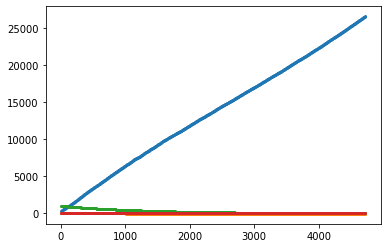

         294170 function calls (288275 primitive calls) in 2.549 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       23    0.000    0.000    2.744    0.119 interactiveshell.py:3215(run_code)
       23    0.000    0.000    2.744    0.119 {built-in method builtins.exec}
        2    0.000    0.000    1.997    0.998 converter.py:713(convert_to_group)
        2    0.000    0.000    1.656    0.828 converter.py:877(copy_to_group)
        2    0.001    0.000    1.655    0.828 converter.py:428(_copy_data)
        9    0.002    0.000    1.597    0.177 _array_converters.py:153(copy)
        9    1.203    0.134    1.405    0.156 _array_converters.py:43(_copy_to_array)
        2    0.000    0.000    0.341    0.170 creator.py:230(create_group)
        2    0.000    0.000    0.341    0.170 pyplot.py:323(show)
        2    0.000    0.000    0.341    0.170 backend_inline.py:23(show)
        2    0.000    0.000    0.336    0.168 core.p

      218    0.000    0.000    0.002    0.000 fromnumeric.py:2404(all)
        8    0.000    0.000    0.002    0.000 spines.py:219(clear)
    11008    0.002    0.000    0.002    0.000 artist.py:832(get_animated)
        2    0.000    0.000    0.002    0.001 display_functions.py:45(publish_display_data)
        2    0.002    0.001    0.002    0.001 {tiledb.libtiledb.group_create}
        2    0.000    0.000    0.002    0.001 zmqshell.py:87(publish)
       99    0.000    0.000    0.002    0.000 transforms.py:2012(rotate_deg)
  317/315    0.001    0.000    0.002    0.000 transforms.py:1122(get_points)
       64    0.000    0.000    0.002    0.000 lines.py:692(_transform_path)
  977/401    0.002    0.000    0.002    0.000 transforms.py:180(_invalidate_internal)
        7    0.000    0.000    0.002    0.000 pyplot.py:833(gcf)
       98    0.001    0.000    0.002    0.000 shape_base.py:612(column_stack)
     1467    0.001    0.000    0.002    0.000 {built-in method builtins.any}
        2   

        9    0.000    0.000    0.001    0.000 creator.py:1058(<listcomp>)
       20    0.001    0.000    0.001    0.000 cycler.py:364(by_key)
       76    0.000    0.000    0.001    0.000 transforms.py:2678(__init__)
       17    0.000    0.000    0.001    0.000 axis.py:439(_get_text2_transform)
        2    0.000    0.000    0.001    0.000 _base.py:1109(_gen_axes_patch)
       13    0.000    0.000    0.001    0.000 creator.py:1122(to_tiledb)
        7    0.000    0.000    0.001    0.000 transforms.py:1408(contains_branch_seperately)
       80    0.000    0.000    0.001    0.000 fromnumeric.py:3257(around)
        4    0.001    0.000    0.001    0.000 core.py:677(__init__)
       26    0.000    0.000    0.001    0.000 patches.py:364(set_facecolor)
     3441    0.001    0.000    0.001    0.000 {method 'append' of 'list' objects}
       17    0.000    0.000    0.001    0.000 _base.py:889(get_xaxis_text2_transform)
      102    0.000    0.000    0.001    0.000 axis.py:1495(convert_units)


      743    0.000    0.000    0.000    0.000 transforms.py:1822(get_affine)
        2    0.000    0.000    0.000    0.000 _base.py:803(_set_lim_and_transforms)
      168    0.000    0.000    0.000    0.000 _methods.py:101(_clip_dep_is_byte_swapped)
      962    0.000    0.000    0.000    0.000 {built-in method builtins.abs}
      448    0.000    0.000    0.000    0.000 {built-in method sys.intern}
        2    0.000    0.000    0.000    0.000 pretty.py:775(_repr_pprint)
      669    0.000    0.000    0.000    0.000 {built-in method builtins.delattr}
      980    0.000    0.000    0.000    0.000 font_manager.py:775(get_size_in_points)
       90    0.000    0.000    0.000    0.000 _collections_abc.py:920(__iter__)
      167    0.000    0.000    0.000    0.000 creator.py:782(dim_creators)
      584    0.000    0.000    0.000    0.000 {method 'replace' of 'str' objects}
      325    0.000    0.000    0.000    0.000 artist.py:271(axes)
       13    0.000    0.000    0.000    0.000 _base.py

        2    0.000    0.000    0.000    0.000 _base.py:2857(<listcomp>)
        4    0.000    0.000    0.000    0.000 transforms.py:1710(__init__)
        2    0.000    0.000    0.000    0.000 {built-in method binascii.b2a_base64}
        2    0.000    0.000    0.000    0.000 Image.py:2634(new)
       15    0.000    0.000    0.000    0.000 getlimits.py:647(__init__)
       14    0.000    0.000    0.000    0.000 lines.py:938(get_markerfacecolor)
        7    0.000    0.000    0.000    0.000 _base.py:786(_request_autoscale_view)
       80    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:893(__enter__)
        4    0.000    0.000    0.000    0.000 transforms.py:1001(intervalx)
      204    0.000    0.000    0.000    0.000 artist.py:604(get_gid)
        4    0.000    0.000    0.000    0.000 backend_bases.py:1694(__init__)
        4    0.000    0.000    0.000    0.000 {method 'all' of 'numpy.ndarray' objects}
      120    0.000    0.000    0.000    0.000 {method 'join' of '

       69    0.000    0.000    0.000    0.000 backend_bases.py:993(get_hatch)
       69    0.000    0.000    0.000    0.000 backend_bases.py:858(get_snap)
        2    0.000    0.000    0.000    0.000 hmac.py:161(hexdigest)
        2    0.000    0.000    0.000    0.000 __init__.py:628(bubble)
        2    0.000    0.000    0.000    0.000 spines.py:539(from_dict)
        2    0.000    0.000    0.000    0.000 copy.py:259(_reconstruct)
       20    0.000    0.000    0.000    0.000 inspect.py:191(isclass)
       12    0.000    0.000    0.000    0.000 axis.py:1352(get_major_locator)
       28    0.000    0.000    0.000    0.000 {method 'values' of 'mappingproxy' objects}
       50    0.000    0.000    0.000    0.000 artist.py:821(get_alpha)
        6    0.000    0.000    0.000    0.000 pretty.py:495(enq)
       32    0.000    0.000    0.000    0.000 ticker.py:559(set_useMathText)
       64    0.000    0.000    0.000    0.000 markers.py:285(get_capstyle)
        8    0.000    0.000    0.000 

        6    0.000    0.000    0.000    0.000 gridspec.py:75(get_geometry)
        2    0.000    0.000    0.000    0.000 linalg.py:106(get_linalg_error_extobj)
        2    0.000    0.000    0.000    0.000 _util.py:5(isPath)
        1    0.000    0.000    0.000    0.000 37000487.py:1(<module>)
        2    0.000    0.000    0.000    0.000 text.py:1171(set_rotation)
        6    0.000    0.000    0.000    0.000 figure.py:2408(get_tight_layout)
        2    0.000    0.000    0.000    0.000 linalg.py:199(_assert_stacked_square)
        2    0.000    0.000    0.000    0.000 PngImagePlugin.py:265(__init__)
        2    0.000    0.000    0.000    0.000 PngImagePlugin.py:1039(__init__)
        4    0.000    0.000    0.000    0.000 artist.py:1092(get_zorder)
        8    0.000    0.000    0.000    0.000 figure.py:2430(get_constrained_layout)
        2    0.000    0.000    0.000    0.000 __init__.py:73(get_projection_class)
        8    0.000    0.000    0.000    0.000 axis.py:1426(<dictcomp>)


In [10]:
## profiles the query performance on sonde_group
cpf.enable()

with tiledb.cf.Group(sonde_group_uri) as sonde_group:
    with (
        sonde_group.open_array(attr="alt") as alt_,
        sonde_group.open_array(attr="tdry") as tdry,
        sonde_group.open_array(attr="pres") as pres,
        sonde_group.open_array(attr="wspd") as wspd,
    ):
        alt_series = alt_[:]
        tdry_series = tdry[:]
        pres_series = pres[:]
        wspd_series = wspd[:]
    

# # COMMENT: this only works with Python 3.9+
# # REQUIRED: python -m pip install --upgrade pip jupyterlab

plt.plot(alt_series, marker=marker, linestyle=linestyle, markersize=markersize)
plt.plot(tdry_series, marker=marker, linestyle=linestyle, markersize=markersize)
plt.plot(pres_series, marker=marker, linestyle=linestyle, markersize=markersize)
plt.plot(wspd_series, marker=marker, linestyle=linestyle, markersize=markersize)
plt.show()

cpf.disable()
cpf.print_stats('cumtime')
